![Colegio Bourbaki](./Images/Bourbaki.png)

### Modelo SARIMAX

**ARIMA** es un modelo de pronóstico para series temporales que combina tres componentes principales:

* **Autoregresivo (AR):** La relación entre una observación y un número de observaciones retrasadas.
* **Integrado (I):** Diferenciación de observaciones crudas para hacer la serie temporal estacionaria, es decir, para eliminar tendencia y estacionalidad.
* **Media Móvil (MA):** Dependencia entre una observación y un error residual móvil proveniente de un modelo de media móvil aplicado a observaciones retrasadas.

La notación ARIMA $(p, d, q)$ describe los componentes del modelo con:

* $p$: El número de términos autoregresivos.
* $d$: El grado de diferenciación.
* $q$: El número de términos de media móvil.

ARIMA es adecuado para series temporales que no tienen un patrón estacional claro o cuando la estacionalidad se ha eliminado previamente.

**SARIMAX** extiende el modelo ARIMA al incorporar componentes adicionales para manejar la estacionalidad y variables exógenas:

* **Componente Estacional:** Similar a la estructura ARIMA pero aplicada a la componente estacional de la serie temporal. Se describe con los parámetros estacionales (P, D, Q)m, donde P, D, y Q representan la autoregresión estacional, la diferenciación estacional, y la media móvil estacional, respectivamente, y m es el número de periodos en cada ciclo estacional.
* **Variables Exógenas (X):** Variables independientes que pueden influir en la serie temporal pero no son parte de la serie en sí. SARIMAX permite incorporar el efecto de estas variables exógenas en el modelo, mejorando la precisión del pronóstico cuando se dispone de información relevante externa.

La inclusión de componentes estacionales y variables exógenas hace que SARIMAX sea particularmente útil en situaciones donde la estacionalidad es pronunciada y/o se desea evaluar el impacto de variables externas en la serie temporal.

### Contexto

Utilizaremos la producción de Petróleo y Gas de Argentina desde 2009-01 hasta 2023-12

### Librerias

In [67]:
# Data Analysis
import pandas as pd

# Series Temporales
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.arima_model import ARIMA
from prophet import Prophet

# Utils
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Funciones de ayuda

In [3]:
def p_value_adfuller(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Se rechaza la hipótesis nula, los datos son estacionarios')
        else:
            print('No se rechaza la hipóteis nula, los datos no son estacionarios')

### Producción de Petróleo y Gas

In [4]:
df_oil = pd.read_csv('./Data/petroleo_diaria_pais.csv')
df_gas = pd.read_csv('./Data/gas_diaria_pais.csv')

In [5]:
df_oil.head()

,anio,mes,indice_tiempo,produccion_petroleo_promedio_dia_m3
0,2009,1,2009-01,97924.5991
1,2009,2,2009-02,100044.0659
2,2009,3,2009-03,99329.5204
3,2009,4,2009-04,98880.3859
4,2009,5,2009-05,98151.9991


In [6]:
df_gas.head()

,anio,mes,indice_tiempo,produccion_gas_promedio_dia_mm3
0,2009,1,2009-01,131223.0108
1,2009,2,2009-02,132833.2683
2,2009,3,2009-03,135361.2048
3,2009,4,2009-04,135493.2462
4,2009,5,2009-05,135374.4330


In [7]:
df = pd.merge(df_oil, df_gas)  

In [8]:
df

,anio,mes,indice_tiempo,produccion_petroleo_promedio_dia_m3,produccion_gas_promedio_dia_mm3
0,2009,1,2009-01,97924.5991,131223.0108
1,2009,2,2009-02,100044.0659,132833.2683
2,2009,3,2009-03,99329.5204,135361.2048
3,2009,4,2009-04,98880.3859,135493.2462
4,2009,5,2009-05,98151.9991,135374.4330
...,...,...,...,...,...
175,2023,8,2023-08,98899.7214,144374.8508
176,2023,9,2023-09,101249.5925,143185.6279
177,2023,10,2023-10,103903.3087,125936.3690
178,2023,11,2023-11,105964.1426,126286.3582


In [9]:
df["Date"] = pd.to_datetime(df["indice_tiempo"])
df = df.set_index('Date')

In [10]:
df['produccion_petroleo_promedio_dia_km3'] = df['produccion_petroleo_promedio_dia_m3']/1000
df['produccion_gas_promedio_dia_Mm3'] = df['produccion_gas_promedio_dia_mm3']/1000

Revisamos si las fechas están ordenadas:

In [11]:
df.index.is_monotonic_increasing

True

Para algunas funciones de ST es importante indicar la frecuencia de nuestros datos:

In [12]:
df.index.freq = df.index.inferred_freq
df.index

DatetimeIndex(['2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='Date', length=180, freq='MS')

Para más información de las frecuencias en pandas consultar el apartado DateOffset objects en [este enlace](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

### Exploración y Visualización de la Serie Temporal

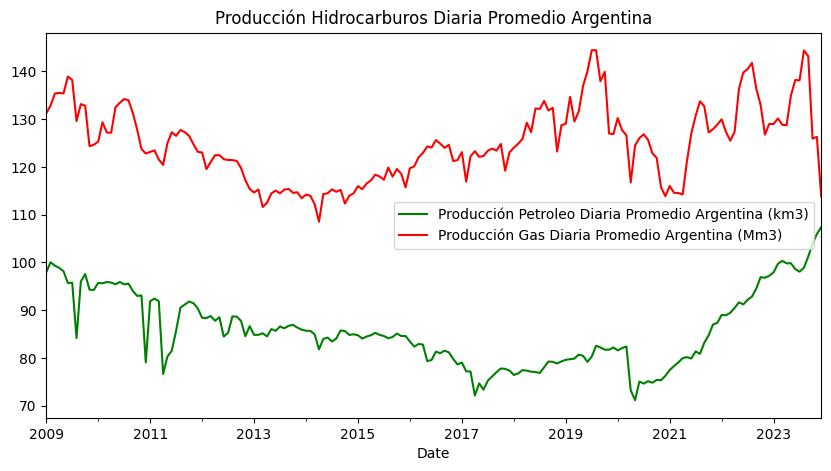

In [13]:
df['produccion_petroleo_promedio_dia_km3'].plot(figsize=(10,5), title='Producción Hidrocarburos Diaria Promedio Argentina', color='green', label='Producción Petroleo Diaria Promedio Argentina (km3)')
df['produccion_gas_promedio_dia_Mm3'].plot(figsize=(10,5), color='red', label='Producción Gas Diaria Promedio Argentina (Mm3)')
plt.legend()
plt.show()

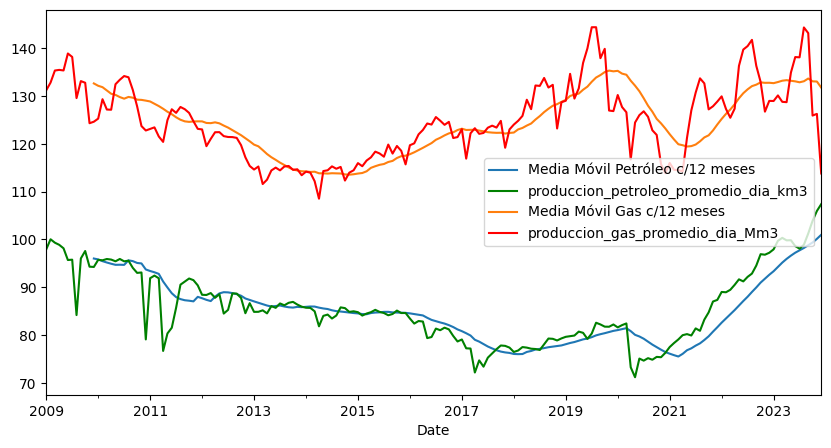

In [14]:
df['produccion_petroleo_promedio_dia_km3'].rolling(12).mean().plot(figsize=(10,5),label='Media Móvil Petróleo c/12 meses')
df['produccion_petroleo_promedio_dia_km3'].plot(color='green')
df['produccion_gas_promedio_dia_Mm3'].rolling(12).mean().plot(figsize=(10,5),label='Media Móvil Gas c/12 meses')
df['produccion_gas_promedio_dia_Mm3'].plot(color='red')
plt.legend()
plt.show()

La funcion seasonal_decompose() de statsmodels, descompone la serie en tres partes: tendencia, estacionalidad y residuos.

**Tendencia:**

La tendencia es un componente de la serie temporal que muestra un patrón persistente y de largo plazo, generalmente hacia arriba o hacia abajo, indicando un aumento o disminución en los datos a lo largo del tiempo. No tiene que ser lineal necesariamente; también puede ser exponencial o de cualquier otra forma que muestre una dirección consistente a lo largo de un período extenso. En SARIMAX, la parte "Integrada" (I) ayuda a manejar y estabilizar la tendencia en los datos, haciendo la serie estacionaria mediante diferenciación, lo cual es esencial para aplicar los componentes AR y MA.

**Estacionalidad:**

La estacionalidad se refiere a patrones o ciclos que se repiten a intervalos regulares dentro de la serie temporal, como diariamente, mensualmente, anualmente, etc. Estos patrones son predecibles y se atribuyen a factores estacionales, como el clima, los hábitos de compra, las festividades, entre otros. La componente "Seasonal" en SARIMAX modela explícitamente esta estacionalidad utilizando términos autoregresivos y de media móvil que se aplican a los ciclos estacionales de los datos, permitiendo que el modelo ajuste y prediga efectivamente estas variaciones periódicas.

**Residuos:**

Los residuos, en el contexto de modelado de series temporales, son la diferencia entre los valores observados y los valores ajustados (o predichos) por el modelo. En un modelo bien ajustado, los residuos deberían ser aleatorios y exhibir propiedades de ruido blanco, lo que significa que no tienen patrones predecibles, no están correlacionados y tienen una media constante cercana a cero. Los residuos representan la parte de la serie temporal que el modelo no puede explicar, y su análisis es crucial para evaluar la adecuación del modelo. Si los residuos muestran patrones no aleatorios o estacionalidad, esto sugiere que el modelo no ha capturado completamente toda la estructura de los datos, indicando la necesidad de revisar y posiblemente mejorar el modelo.


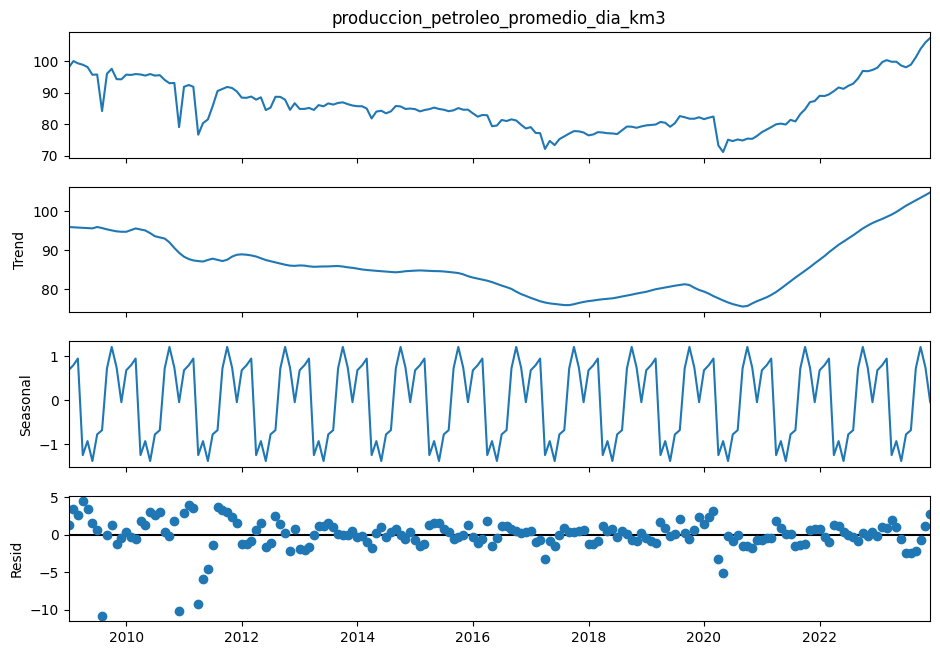

In [15]:
decomp_oil = seasonal_decompose(df['produccion_petroleo_promedio_dia_km3'], period=12, extrapolate_trend='freq')
fig = decomp_oil.plot()
fig.set_size_inches(10,7)

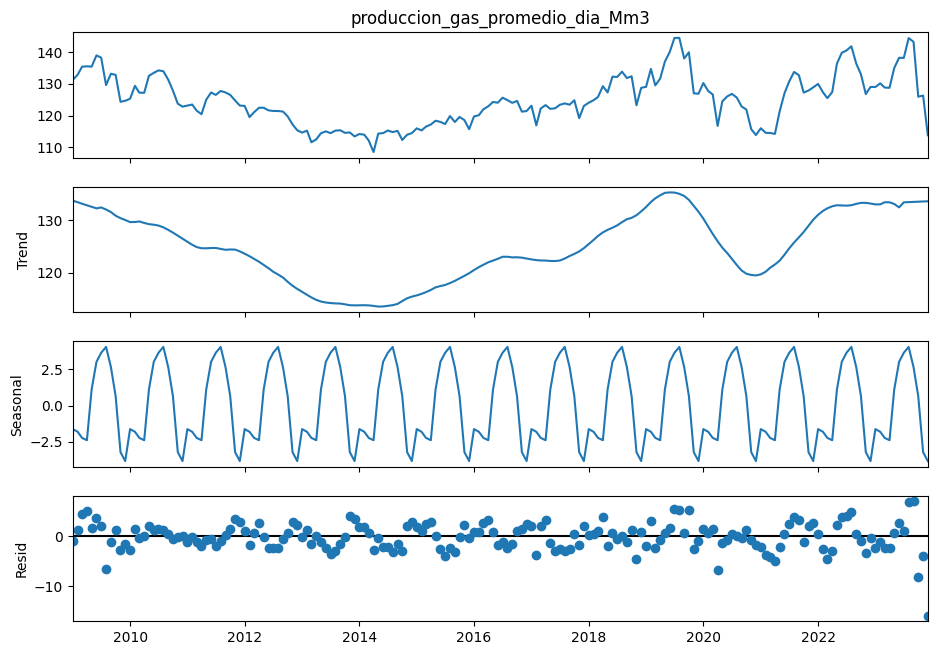

In [16]:
decomp_gas = seasonal_decompose(df['produccion_gas_promedio_dia_Mm3'], period=12, extrapolate_trend='freq')
fig = decomp_gas.plot()
fig.set_size_inches(10,7)

### Datos Estacionarios

El test de Dickey-Fuller, específicamente el test de Dickey-Fuller Aumentado (ADF, por sus siglas en inglés Augmented Dickey-Fuller), es una prueba estadística utilizada para determinar si una serie temporal es estacionaria o no, enfocándose en la presencia de una raíz unitaria. Una serie temporal es estacionaria si sus propiedades estadísticas, como la media y la varianza, son constantes a lo largo del tiempo. La estacionalidad es una propiedad deseada en muchos modelos de series temporales porque facilita la predicción de futuros valores.

El test de Dickey-Fuller Aumentado verifica la hipótesis nula $(H_0​)$ de que una serie temporal tiene una raíz unitaria, lo que indica que no es estacionaria. Una raíz unitaria significa que la serie temporal puede ser representada por un proceso autorregresivo que tiene uno o más coeficientes igual a uno, lo cual es indicativo de un patrón persistente que no retorna a una media a largo plazo.

**Hipótesis del Test:**

* Hipótesis Nula $(H_0​)$: La serie temporal tiene una raíz unitaria (no es estacionaria).
* Hipótesis Alternativa $(H_1​)$: La serie temporal no tiene una raíz unitaria (es estacionaria).

**Interpretación del Test:**

La decisión de rechazar o no la hipótesis nula se basa en el valor p del test. Si el valor p es menor que un nivel de significancia predefinido (por ejemplo, 0.05), entonces se rechaza la hipótesis nula en favor de la hipótesis alternativa, sugiriendo que la serie temporal es estacionaria.

El test de Dickey-Fuller Aumentado es una herramienta esencial en el análisis de series temporales, especialmente antes de ajustar modelos como ARIMA, donde la estacionariedad de la serie es un requisito. Identificar y corregir la no estacionariedad (por ejemplo, mediante diferenciación) es un paso crítico en el proceso de modelado de series temporales.

**Limitaciones:**

Aunque el test ADF es ampliamente utilizado, tiene algunas limitaciones, como su sensibilidad al número de retrasos incluidos en el modelo y su tendencia a no detectar estacionariedad en presencia de cambios estructurales en la serie temporal. Por estas razones, a menudo se utiliza en conjunto con otras pruebas y análisis gráficos para una evaluación más completa de la estacionariedad.

Primero, veamos el clase de la serie temporal del petróleo:

In [17]:
oil_pValue = adfuller(df['produccion_petroleo_promedio_dia_km3'])[1]
oil_pValue

0.8599134312425288

In [18]:
p_value_adfuller(df['produccion_petroleo_promedio_dia_km3'])

P-value:  0.8599134312425288
No se rechaza la hipóteis nula, los datos no son estacionarios


Como los datos no son estacionarios, no se rechazan la hipótesis nula. Vamos a hacer un shift de una unidad:

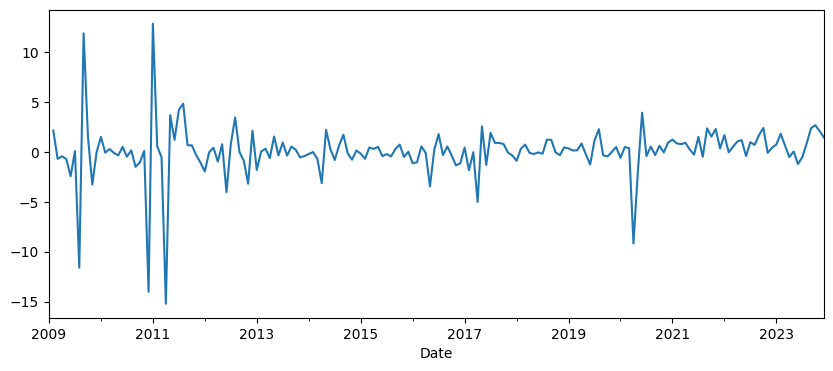

In [19]:
df['1a_diffoil']= df['produccion_petroleo_promedio_dia_km3'] - df['produccion_petroleo_promedio_dia_km3'].shift(1) 
df['1a_diffoil'].plot(figsize=(10,4))
plt.show()

In [20]:
p_value_adfuller(df['1a_diffoil'].dropna())

P-value:  1.5134553510520321e-18
Se rechaza la hipótesis nula, los datos son estacionarios


Veamos el caso de la serie del Gas:

In [21]:
gas_pValue = adfuller(df['produccion_gas_promedio_dia_Mm3'])[1]
gas_pValue

0.018403231446106012

In [22]:
p_value_adfuller(df['produccion_gas_promedio_dia_Mm3'])

P-value:  0.018403231446106012
Se rechaza la hipótesis nula, los datos son estacionarios


Los datos son estacionarios.

### Visualización de la ACF y PACF

Para el petróleo:

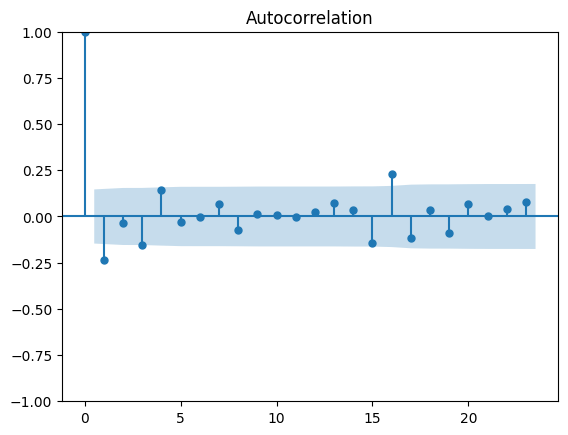

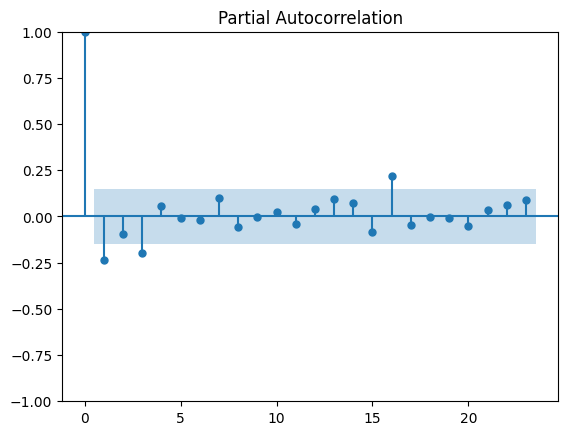

In [23]:
plot_acf(df['1a_diffoil'].dropna())
plot_pacf(df['1a_diffoil'].dropna())
plt.show()

Para el gas:

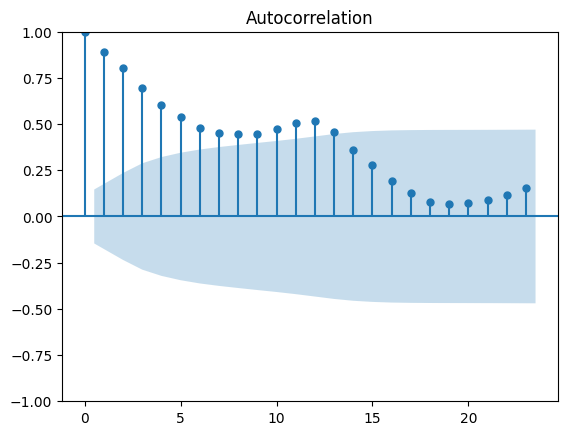

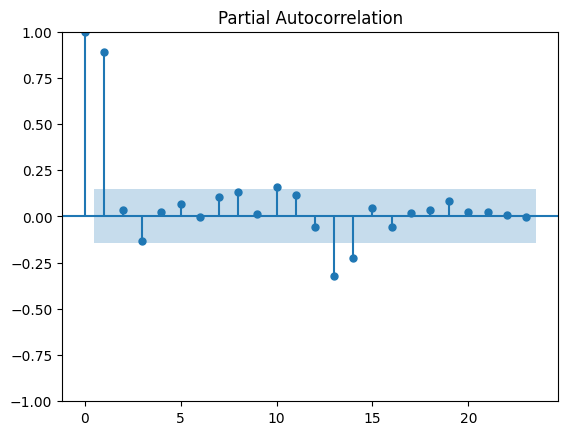

In [24]:
plot_acf(df['produccion_gas_promedio_dia_Mm3'])
plot_pacf(df['produccion_gas_promedio_dia_Mm3'])
plt.show()

### Construcción del modelo SARIMAx

In [25]:
train_oil = df.loc[:'2023-1-1','produccion_petroleo_promedio_dia_km3']
test_oil = df.loc['2023-1-1':,'produccion_petroleo_promedio_dia_km3']
train_gas = df.loc[:'2023-1-1','produccion_gas_promedio_dia_Mm3']
test_gas = df.loc['2023-1-1':,'produccion_gas_promedio_dia_Mm3']

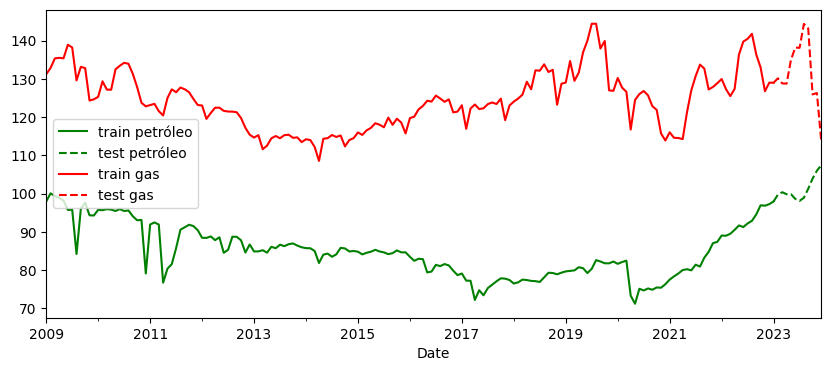

In [26]:
train_oil.plot(label = 'train petróleo', figsize =(10,4), color='green')
test_oil.plot(label = 'test petróleo', figsize =(10,4), color='green', linestyle='--')
train_gas.plot(label = 'train gas', figsize =(10,4), color='red')
test_gas.plot(label = 'test gas', figsize =(10,4), color='red', linestyle='--')
plt.legend()
plt.show()

In [27]:
len(train_oil), len(test_oil)

(169, 12)

In [28]:
print(f'Porcentaje de datos de prueba para el petróleo: {100*len(test_oil)/(len(train_oil)+len(test_oil)):.2f}')
print(f'Porcentaje de datos de prueba para el gas: {100*len(test_gas)/(len(train_gas)+len(test_gas)):.2f}')

Porcentaje de datos de prueba para el petróleo: 6.63
Porcentaje de datos de prueba para el gas: 6.63


Vamos a generar una combinación de los parámetros de los modelos SARIMAX:

In [29]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [30]:
p = d =  q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 0, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12)]

El criterio de información de Akaike (AIC, por sus siglas en inglés, Akaike Information Criterion) es una medida utilizada en estadística para la selección de modelos. En el contexto del código que proporcionaste, donde se ajustan modelos SARIMAX a series temporales, el AIC se utiliza para comparar diferentes modelos entre sí y seleccionar el mejor.

El AIC es un criterio basado en la teoría de la información que busca encontrar el modelo que mejor explica los datos con la menor cantidad de parámetros. Proporciona un balance entre la complejidad del modelo (número de parámetros) y su ajuste a los datos. Un modelo que se ajusta perfectamente pero que usa demasiados parámetros puede capturar el ruido en lugar de la señal (overfitting), mientras que un modelo con pocos parámetros puede no capturar toda la estructura de los datos (underfitting).

Interpretación del AIC

* Valor Absoluto del AIC: Por sí solo, el valor absoluto del AIC no tiene un significado inherente. Lo importante es la diferencia relativa en los valores de AIC entre diferentes modelos.
* Comparación de Modelos: Entre dos o más modelos, el que tiene el menor AIC se considera el "mejor", en el sentido de que tiene un equilibrio óptimo entre ajuste y complejidad.
* Diferencia de AIC: Una diferencia de AIC de 2 o más se considera sustancial. Sin embargo, cuando las diferencias son pequeñas (por ejemplo, menos de 2), puede no haber una preferencia clara entre los modelos comparados.

Aplicación en SARIMAX

En el ajuste de modelos SARIMAX a datos de series temporales, el AIC se utiliza para elegir entre diferentes combinaciones de órdenes autoregresivas (AR), integradas (I), medias móviles (MA), y componentes estacionales. Seleccionar el modelo con el AIC más bajo ayuda a prevenir tanto la sobreadaptación como la subadaptación, facilitando la elección de un modelo que generalice bien a nuevos datos.

In [31]:
%%time

aic_modelos_oil = {}
aic_modelos_gas = {}

# Loop para iterar a través de combinaciones de parámetros.
for parametros in pdq:
    for parametros_s in seasonal_pdq:
        try:
            modelo_oil = SARIMAX(df.loc[:'2023-1-1', 'produccion_petroleo_promedio_dia_km3'],
                             order=parametros,
                             seasonal_order=parametros_s,
                             enforce_stationarity=False,
                             enforce_invertibility=False)
            results_oil = modelo_oil.fit(disp=False)  # Añadido disp=False para minimizar la salida durante el ajuste
            aic_modelos_oil[(parametros, parametros_s)] = results_oil.aic
            print(f'Petróleo: ARIMA{parametros}x{parametros_s} - AIC:{results_oil.aic}')
        except Exception as e:
            print(f'Error con ARIMA{parametros}x{parametros_s}: {e}')
            continue
        try:
            modelo_gas = SARIMAX(df.loc[:'2023-1-1', 'produccion_gas_promedio_dia_Mm3'],
                             order=parametros,
                             seasonal_order=parametros_s,
                             enforce_stationarity=False,
                             enforce_invertibility=False)
            results_gas = modelo_gas.fit(disp=False)
            aic_modelos_gas[(parametros, parametros_s)] = results_gas.aic
            print(f'Gas: ARIMA{parametros}x{parametros_s} - AIC:{results_gas.aic}')
        except Exception as e:
            print(f'Error con ARIMA{parametros}x{parametros_s}: {e}')
            continue

Petróleo: ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:1971.6767121540033
Gas: ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:2100.0698872499597
Petróleo: ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1660.8034997283844
Gas: ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1779.3412240159805
Petróleo: ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:1399.7830251367634
Gas: ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:1508.7569654543263
Petróleo: ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:996.3023544868984
Gas: ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:1056.629304775734
Petróleo: ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:920.0738587160008
Gas: ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:981.2923542937339
Petróleo: ARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:817.9045380347545
Gas: ARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:889.480390824905
Petróleo: ARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:1011.5774658853942
Gas: ARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:1088.7260826478112
Petróleo: ARIMA(0, 0, 0)x(0, 2, 1, 12) - AIC:855.1054573881061
Gas: ARIMA(0, 0, 0)x(0, 2, 1, 12) - AIC:938.7257967462546
Petróleo: ARIMA(0, 0, 0)x

In [32]:
print('Modelo Petróleo: ', min(aic_modelos_oil, key = aic_modelos_oil.get))
print('AIC Petróleo: ',min(aic_modelos_oil.values()))
print('Modelo Gas: ', min(aic_modelos_gas, key = aic_modelos_gas.get))
print('AIC Gas: ',min(aic_modelos_gas.values()))

Modelo Petróleo:  ((2, 1, 2), (2, 1, 2, 12))
AIC Petróleo:  503.26526109302097
Modelo Gas:  ((2, 0, 2), (2, 2, 2, 12))
AIC Gas:  610.8754928402651


Para el petróleo:

In [33]:
sarimax_oil = SARIMAX(df['produccion_petroleo_promedio_dia_km3'],
                       order = (2,1,2),
                       seasonal_order = (2,1,2,12),
                       enforce_stationarity = False,
                       enforce_invertibility = False)
resultados_oil = sarimax_oil.fit()
print(resultados_oil.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77066D+00    |proj g|=  1.59321D-01


 This problem is unconstrained.



At iterate    5    f=  1.49790D+00    |proj g|=  9.41259D-02

At iterate   10    f=  1.48872D+00    |proj g|=  2.81906D-02

At iterate   15    f=  1.48411D+00    |proj g|=  5.40156D-02

At iterate   20    f=  1.47525D+00    |proj g|=  6.28421D-02

At iterate   25    f=  1.46942D+00    |proj g|=  4.45656D-02

At iterate   30    f=  1.46562D+00    |proj g|=  3.48007D-02

At iterate   35    f=  1.46472D+00    |proj g|=  1.08714D-02

At iterate   40    f=  1.46468D+00    |proj g|=  7.94780D-04

At iterate   45    f=  1.46468D+00    |proj g|=  2.78960D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46     58   

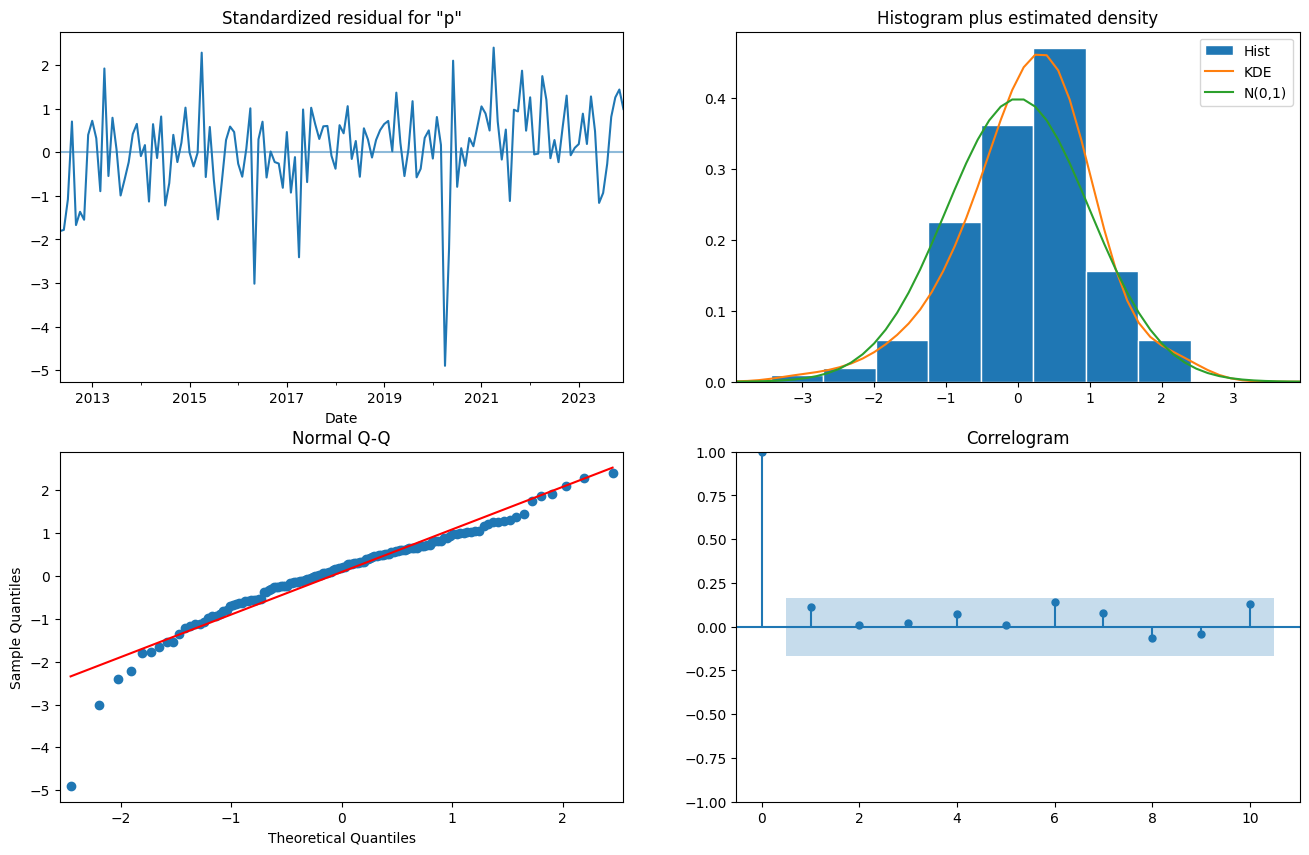

In [34]:
resultados_oil.plot_diagnostics(figsize = (16,10))
plt.show()

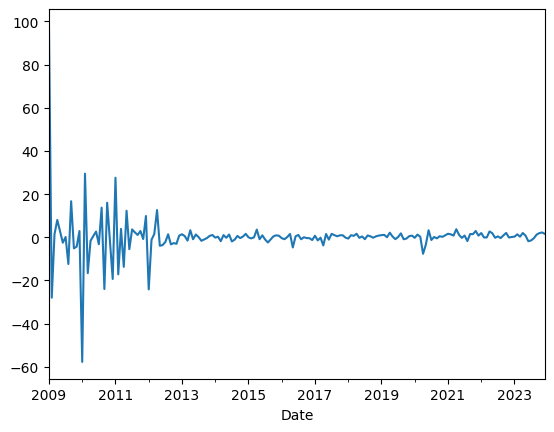

In [35]:
resultados_oil.resid.plot()
plt.show()

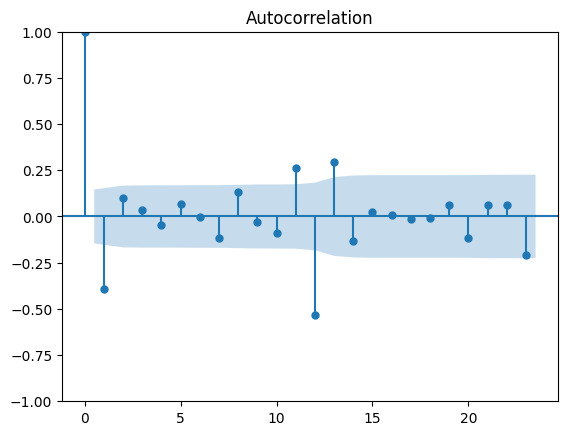

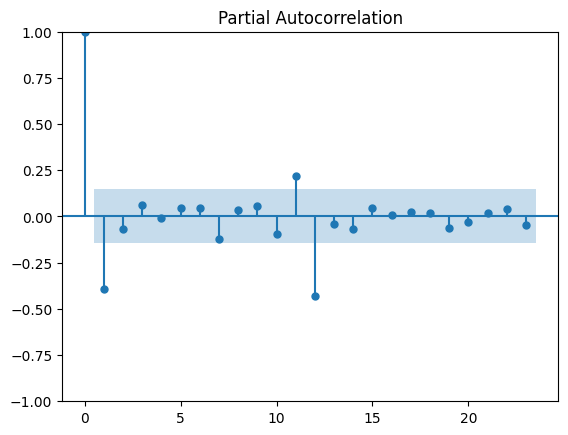

In [36]:
plot_acf(resultados_oil.resid)
plot_pacf(resultados_oil.resid)
plt.show()

Para el gas:

In [77]:
sarimax_gas = SARIMAX(df['produccion_gas_promedio_dia_Mm3'],
                       order = (2,0,2),
                       seasonal_order = (2,2,2,12),
                       enforce_stationarity = False,
                       enforce_invertibility = False)
resultados_gas = sarimax_gas.fit()
print(resultados_gas.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06329D+00    |proj g|=  2.49920D-01

At iterate    5    f=  1.97989D+00    |proj g|=  1.68638D-01

At iterate   10    f=  1.90833D+00    |proj g|=  3.46275D-02

At iterate   15    f=  1.90778D+00    |proj g|=  2.24633D-03

At iterate   20    f=  1.90765D+00    |proj g|=  4.89718D-03

At iterate   25    f=  1.90568D+00    |proj g|=  1.88886D-02

At iterate   30    f=  1.90412D+00    |proj g|=  4.03955D-03

At iterate   35    f=  1.90407D+00    |proj g|=  3.53798D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

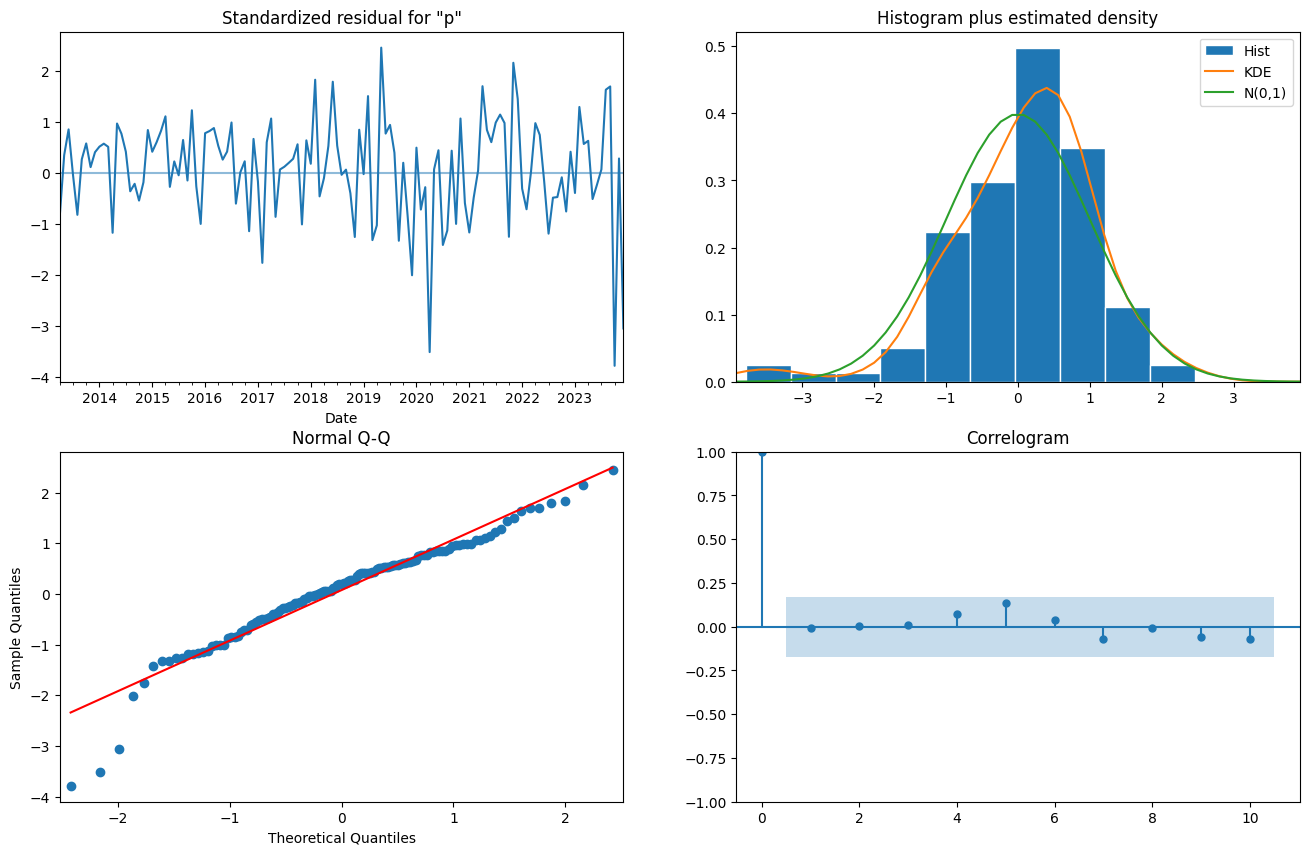

In [78]:
resultados_gas.plot_diagnostics(figsize = (16,10))
plt.show()

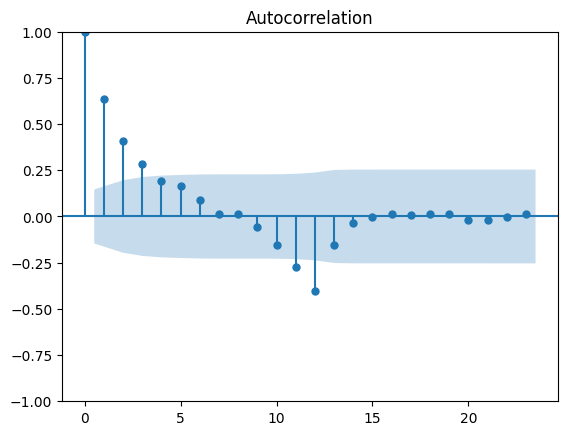

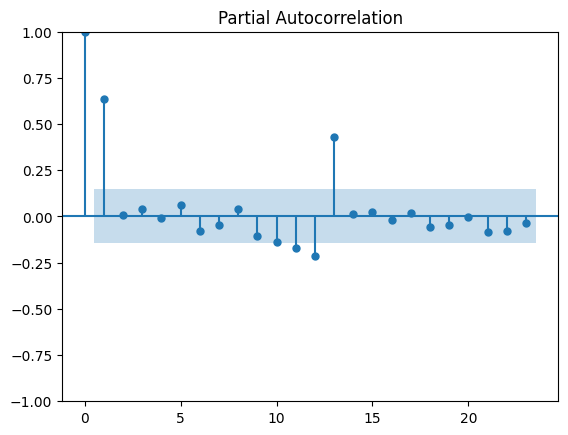

In [79]:
plot_acf(resultados_gas.resid)
plot_pacf(resultados_gas.resid)
plt.show()

### Testing

In [80]:
pred_oil = resultados_oil.get_prediction(start=pd.to_datetime('2023-01-01'),
                                 end=pd.to_datetime('2026-01-01'))
pred_IC_oil = pred_oil.conf_int()
pred_gas = resultados_gas.get_prediction(start=pd.to_datetime('2023-01-01'),
                                 end=pd.to_datetime('2026-01-01'))
pred_IC_gas = pred_gas.conf_int()

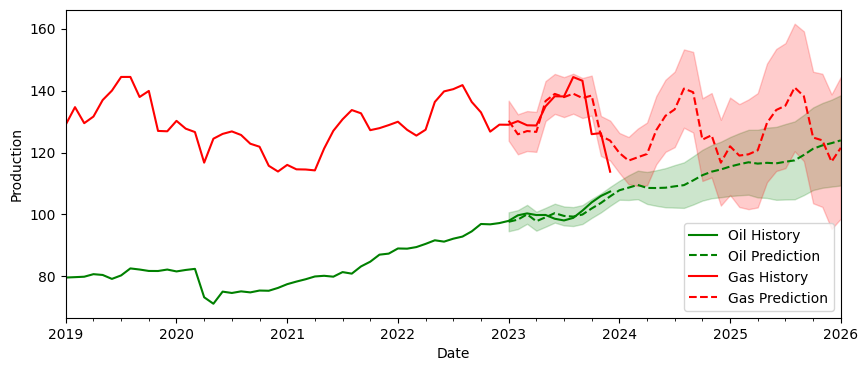

In [93]:
fig = df.loc['2019-01-01':,'produccion_petroleo_promedio_dia_km3'].plot(label = 'Oil History', 
                                           figsize =(10,4), color='green')
pred_oil.predicted_mean.plot(ax = fig, label = 'Oil Prediction', color='green', linestyle='--')
fig.fill_between(pred_IC_oil.index, 
                 pred_IC_oil.iloc[:,0], pred_IC_oil.iloc[:,1], 
                 color='green', alpha=.2)
fig = df.loc['2019-01-01':,'produccion_gas_promedio_dia_Mm3'].plot(label = 'Gas History', 
                                           figsize =(10,4), color='red')
pred_gas.predicted_mean.plot(ax = fig, label = 'Gas Prediction', color='red', linestyle='--')
fig.fill_between(pred_IC_gas.index, 
                 pred_IC_gas.iloc[:,0], pred_IC_gas.iloc[:,1], 
                 color='red', alpha=.2)
plt.ylabel('Production')
plt.legend()
plt.show()

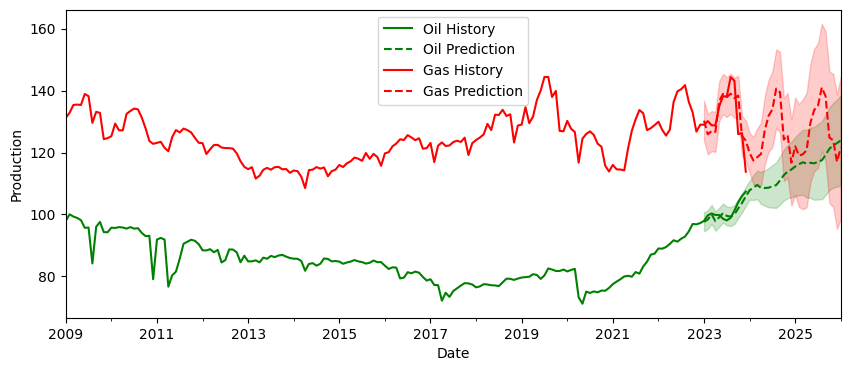

In [94]:
fig = df.loc['2009-01-01':,'produccion_petroleo_promedio_dia_km3'].plot(label = 'Oil History', 
                                           figsize =(10,4), color='green')
pred_oil.predicted_mean.plot(ax = fig, label = 'Oil Prediction', color='green', linestyle='--')
fig.fill_between(pred_IC_oil.index, 
                 pred_IC_oil.iloc[:,0], pred_IC_oil.iloc[:,1], 
                 color='green', alpha=.2)

fig = df.loc['2009-01-01':,'produccion_gas_promedio_dia_Mm3'].plot(label = 'Gas History', 
                                           figsize =(10,4), color='red')
pred_gas.predicted_mean.plot(ax = fig, label = 'Gas Prediction', color='red', linestyle='--')
fig.fill_between(pred_IC_gas.index, 
                 pred_IC_gas.iloc[:,0], pred_IC_gas.iloc[:,1], 
                 color='red', alpha=.2)

plt.ylabel('Production')
plt.legend()
plt.show()

In [102]:
y_pred_oil  = pred_oil.predicted_mean
y_real_oil = df.loc['2023-01-01':'2026-01-01','produccion_petroleo_promedio_dia_km3']
mse = ((y_pred_oil - y_real_oil) ** 2).mean()
print(f'El error cuadrático medio es {round(mse, 2)}')
print(f'La raiz del error cuadrático medio es {round(np.sqrt(mse), 2)}')
print(f"Porcentaje de error con respecto al promedio: {round(100*np.sqrt(mse)/(df['produccion_petroleo_promedio_dia_km3'].mean()), 3)} %")

El error cuadrático medio es 2.09
La raiz del error cuadrático medio es 1.45
Porcentaje de error con respecto al promedio: 1.685 %


In [103]:
y_pred_gas  = pred_gas.predicted_mean
y_real_gas = df.loc['2023-01-01':'2026-01-01','produccion_gas_promedio_dia_Mm3']
mse = ((y_pred_gas - y_real_gas) ** 2).mean()
print(f'El error cuadrático medio es {round(mse, 2)}')
print(f'La raiz del error cuadrático medio es {round(np.sqrt(mse), 2)}')
print(f"Porcentaje de error con respecto al promedio: {round(100*np.sqrt(mse)/(df['produccion_gas_promedio_dia_Mm3'].mean()), 3)} %")

El error cuadrático medio es 29.0
La raiz del error cuadrático medio es 5.39
Porcentaje de error con respecto al promedio: 4.312 %


### Prophet

In [115]:
#Convert 'date' to datetime and rename columns for Prophet
df_oil['ds'] = pd.to_datetime(df_oil['indice_tiempo'])
df_oil.rename(columns={'produccion_petroleo_promedio_dia_m3': 'y'}, inplace=True)
df_gas['ds'] = pd.to_datetime(df_oil['indice_tiempo'])
df_gas.rename(columns={'produccion_gas_promedio_dia_mm3': 'y'}, inplace=True)

In [113]:
df_oil

,y,ds
0,97924.5991,2009-01-01
1,100044.0659,2009-02-01
2,99329.5204,2009-03-01
3,98880.3859,2009-04-01
4,98151.9991,2009-05-01
...,...,...
175,98899.7214,2023-08-01
176,101249.5925,2023-09-01
177,103903.3087,2023-10-01
178,105964.1426,2023-11-01


In [116]:
df_gas

,y,ds
0,131223.0108,2009-01-01
1,132833.2683,2009-02-01
2,135361.2048,2009-03-01
3,135493.2462,2009-04-01
4,135374.4330,2009-05-01
...,...,...
175,144374.8508,2023-08-01
176,143185.6279,2023-09-01
177,125936.3690,2023-10-01
178,126286.3582,2023-11-01


In [107]:
# Drop the original 'date' column as it's no longer needed
df_oil.drop(columns=['anio', 'mes', 'indice_tiempo'], inplace=True)
df_gas.drop(columns=['anio', 'mes', 'indice_tiempo'], inplace=True)

In [120]:
df_oil['y'] = df_oil['y']/1000
df_gas['y'] = df_gas['y']/1000

In [121]:
df_oil

,y,ds
0,97.924599,2009-01-01
1,100.044066,2009-02-01
2,99.329520,2009-03-01
3,98.880386,2009-04-01
4,98.151999,2009-05-01
...,...,...
175,98.899721,2023-08-01
176,101.249593,2023-09-01
177,103.903309,2023-10-01
178,105.964143,2023-11-01


In [122]:
df_gas

,y,ds
0,131.223011,2009-01-01
1,132.833268,2009-02-01
2,135.361205,2009-03-01
3,135.493246,2009-04-01
4,135.374433,2009-05-01
...,...,...
175,144.374851,2023-08-01
176,143.185628,2023-09-01
177,125.936369,2023-10-01
178,126.286358,2023-11-01


In [123]:
# Initialize the Prophet model
model_oil = Prophet(yearly_seasonality=True)
model_gas = Prophet(yearly_seasonality=True)

# Fit the model with the oil production DataFrame
model_oil.fit(df_oil)
model_gas.fit(df_gas)

20:00:08 - cmdstanpy - INFO - Chain [1] start processing


20:00:08 - cmdstanpy - INFO - Chain [1] done processing
20:00:08 - cmdstanpy - INFO - Chain [1] start processing
20:00:08 - cmdstanpy - INFO - Chain [1] done processing


In [136]:
# Make a future DataFrame for the next 24 months
future_oil = model_oil.make_future_dataframe(periods=24, freq='ME')
future_gas = model_gas.make_future_dataframe(periods=24, freq='ME')

In [137]:
# Predict the future oil production
forecast_oil = model_oil.predict(future_oil)
forecast_gas = model_gas.predict(future_gas)

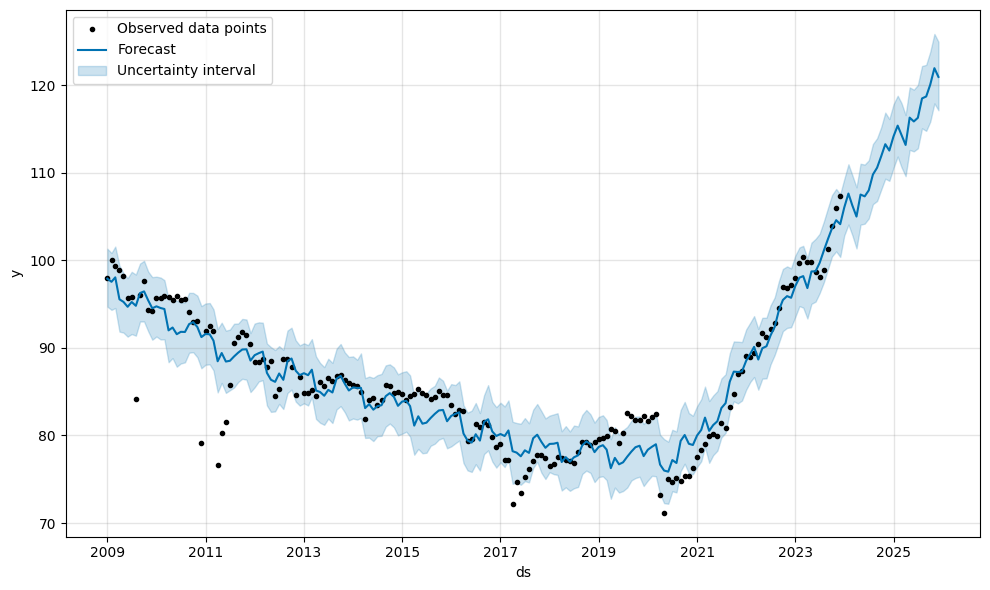

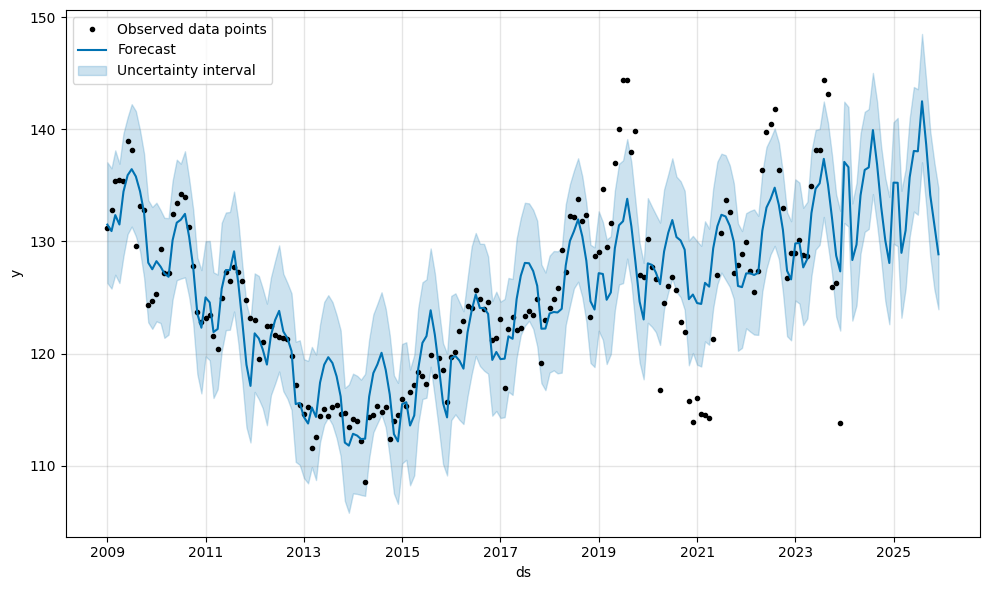

In [138]:
# Plot the forecast
fig=model_oil.plot(forecast_oil, include_legend=True)
fig=model_gas.plot(forecast_gas, include_legend=True)

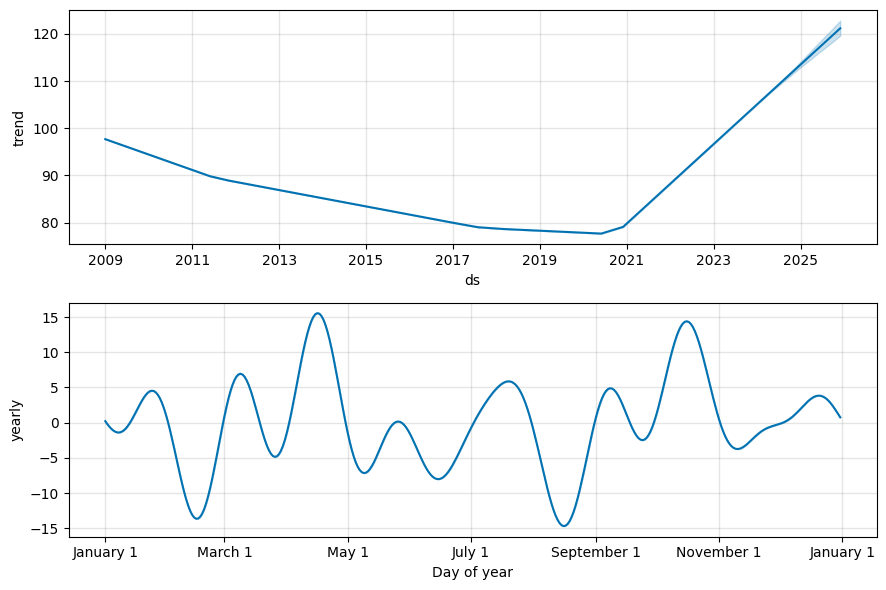

In [139]:
fig_components_oil = model_oil.plot_components(forecast_oil)

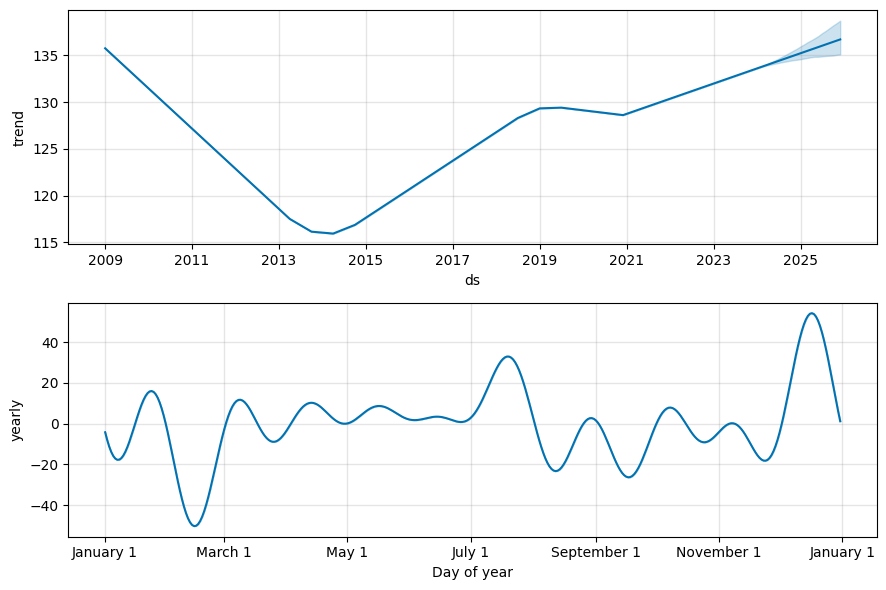

In [140]:
fig_components_gas = model_gas.plot_components(forecast_gas)

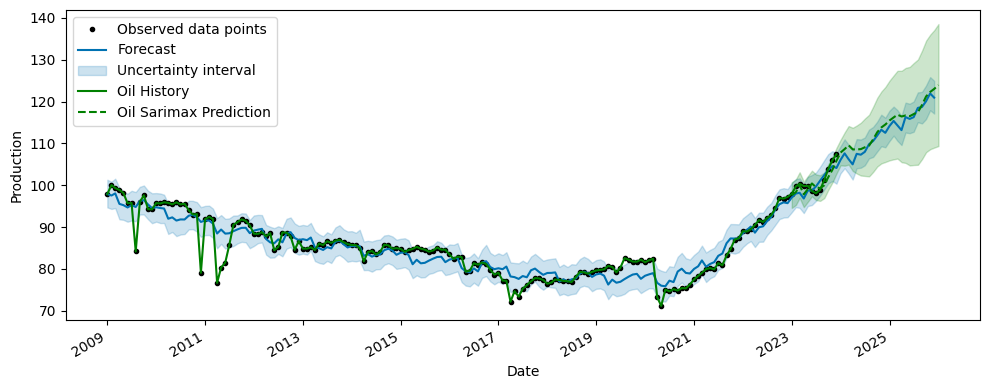

In [142]:
fig=model_oil.plot(forecast_oil, include_legend=True)
fig=df.loc['2009-01-01':,'produccion_petroleo_promedio_dia_km3'].plot(label = 'Oil History', 
                                           figsize =(10,4), color='green')
pred_oil.predicted_mean.plot(ax = fig, label = 'Oil Sarimax Prediction', color='green', linestyle='--')
fig.fill_between(pred_IC_oil.index, 
                 pred_IC_oil.iloc[:,0], pred_IC_oil.iloc[:,1], 
                 color='green', alpha=.2)

plt.ylabel('Production')
plt.legend()
plt.show()

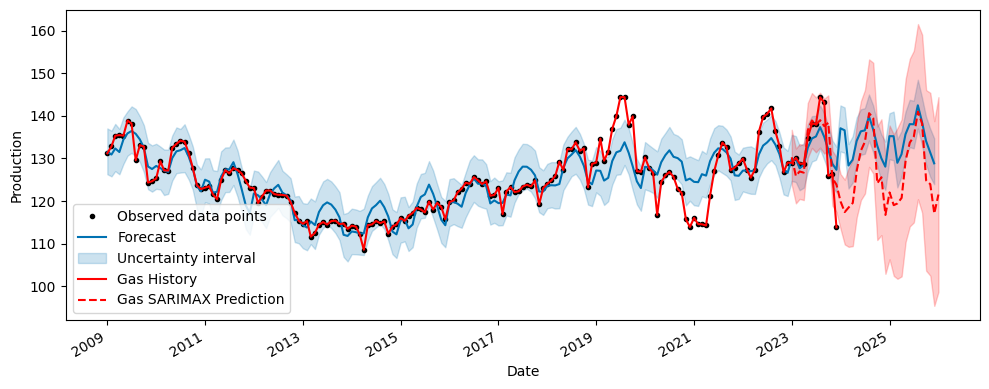

In [143]:
fig=model_gas.plot(forecast_gas, include_legend=True)
fig = df.loc['2009-01-01':,'produccion_gas_promedio_dia_Mm3'].plot(label = 'Gas History', 
                                           figsize =(10,4), color='red')
pred_gas.predicted_mean.plot(ax = fig, label = 'Gas SARIMAX Prediction', color='red', linestyle='--')
fig.fill_between(pred_IC_gas.index, 
                 pred_IC_gas.iloc[:,0], pred_IC_gas.iloc[:,1], 
                 color='red', alpha=.2)
plt.ylabel('Production')
plt.legend()
plt.show()


In [ ]:
def custom_metrics(df):
    errors = df['error'].astype(float)
    
    n = len(errors)
    MSE = np.mean(np.square(errors))
    RMSE = np.sqrt(MSE)
    MAE = np.mean(np.abs(errors))
    
    non_zero_idx = df['actual'] != 0
    percentage_errors = 100 * (errors[non_zero_idx] / df['actual'][non_zero_idx])
    
    MAPE = np.mean(np.abs(percentage_errors))
    MDAPE = np.median(np.abs(percentage_errors))
    SMAPE = np.mean(200 * np.abs(df['error']) / (np.abs(df['predicted']) + np.abs(df['actual'])))
    
    results_df = pd.DataFrame({'MSE': MSE, 'RMSE': RMSE, 'MAE': MAE, 'MAPE': MAPE, 'MDAPE': MDAPE, 'SMAPE': SMAPE}, index=[0])
    return results_df

def compare_metrics(df_model1, df_model2):
    metrics_model1 = custom_metrics(df_model1)
    metrics_model2 = custom_metrics(df_model2)
    
    metrics_model1.index = ['SARIMAX']
    metrics_model2.index = ['Prophet']
    
    combined_metrics = pd.concat([metrics_model1, metrics_model2])
    return combined_metrics

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)